In [1]:
from poker_utils.constants import HANDS_DICT, HANDS
from poker_utils.hands import find_dominated_hands, find_blocked_hands_simple
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
hand_chart = pd.read_excel('data/raw/hand_chart.xlsx')
data = pd.read_csv('data/raw/hand_data.csv')

In [3]:
G = nx.DiGraph()
for row in range(13):
    for col in range(13):
        hand = hand_chart.iloc[row, col]
        G.add_node(hand)

In [4]:
for source in G.nodes():
    blocked_hands_dict = find_blocked_hands_simple(source)
    dominated_hands_dict = find_dominated_hands(source)
    for dest in G.nodes():
        blocks = 1.0 if dest in blocked_hands_dict else 0.0
        if blocks == 1.0:
            combinations_blocked = blocked_hands_dict[dest]
        else:
            combinations_blocked = 0.0
            
        dominates = 1.0 if dest in dominated_hands_dict else 0.0
        if dominates == 1.0:
            combinations_dominated = dominated_hands_dict[dest]
        else:
            combinations_dominated = 0.0

        G.add_edge(source, dest, 
                   blocks=blocks, 
                   dominates=dominates, 
                   combinations_blocked=combinations_blocked,
                   combinations_dominated=combinations_dominated)

In [5]:
results = {}
for node in G.nodes():
    dominates_count = 0
    combos_dominated = 0
    combos_blocked = 0
    blocks_count = 0
    for source, dest, data in G.out_edges(node, data=True):
        dominates_count += data['dominates']
        combos_blocked += data['combinations_blocked']
        blocks_count += data['blocks']
        combos_dominated += data['combinations_dominated']

    dominated_by_count = 0
    blocked_by_count = 0
    combos_blocked_by_count = 0
    combos_dominated_by_count = 0
    for source, dest, data in G.in_edges(node, data=True):
        dominated_by_count += data['dominates']
        combos_blocked_by_count += data['combinations_blocked']
        blocked_by_count+= data['blocks']
        combos_dominated_by_count += data['combinations_dominated']
    
    results[node] = {
            'dominates_count': dominates_count,
            "combos_dominated": combos_dominated,
            
            'blocks_count': blocks_count,
            'combos_blocked': combos_blocked,
            
            'blocked_by_count': blocked_by_count,
            'combos_blocked_by_count': combos_blocked_by_count,
            
            'dominated_by_count': dominated_by_count,
            "combos_dominated_by_count": combos_dominated_by_count
    }
    
df = pd.DataFrame.from_dict(results, orient='index')

In [6]:
df["dom_ratio"] = df['combos_dominated'] / np.where(df['combos_dominated_by_count'] == 0, 1, df['combos_dominated_by_count'])
df["block_ratio"] = df['combos_blocked'] / np.where(df['combos_blocked_by_count'] == 0, 1, df['combos_blocked_by_count'])
df["dom_block_ratio"] = df['combos_dominated'] / np.where(df['combos_blocked_by_count'] == 0, 1, df['combos_blocked_by_count'])

In [7]:
df['block_ratio'].value_counts()

block_ratio
2.000000    78
0.649351    78
1.315789    13
Name: count, dtype: int64

In [8]:
df['block_ratio_cat'] = np.select(
    condlist=[
        df['block_ratio'] > 1.5,
        (df['block_ratio'] > 1) & (df['block_ratio'] < 1.5),
        df['block_ratio'] < 1
        ],
    choicelist=[
        2,
        1,
        0
    ]
)

In [9]:
df[['block_ratio', 'dom_ratio','dom_block_ratio']].corr()

,block_ratio,dom_ratio,dom_block_ratio
block_ratio,1.000000,0.041800,0.686286
dom_ratio,0.041800,1.000000,0.051408
dom_block_ratio,0.686286,0.051408,1.000000


In [10]:
df.index.name = "hand"
df.reset_index(inplace=True)

In [ ]:
# df.to_csv("data/raw/dom_block_data.csv", index=False)

In [12]:
X = df.set_index("hand")[['dominates_count', 'combos_dominated', 'blocks_count',
       'combos_blocked', 'blocked_by_count', 'combos_blocked_by_count',
       'dominated_by_count', 'combos_dominated_by_count']].copy()

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.45477134 0.3664604 ]


In [15]:
X.reset_index(inplace=True)

In [16]:
X['pc1'] = X_pca[:,0]
X['pc2'] = X_pca[:,1]

In [17]:
X['suited'] = (X['hand'].str[-1] == 's')
X['pair'] = (X['hand'].str[0] == X['hand'].str[1])

In [18]:
X['hand_type'] = np.select(
    condlist=[
        (X['pair'] == True),
        (X['suited'] == False),
        (X['suited'] == True),
    ],
    choicelist=['pair', 'offsuit', 'suited'],
    default='other'
)

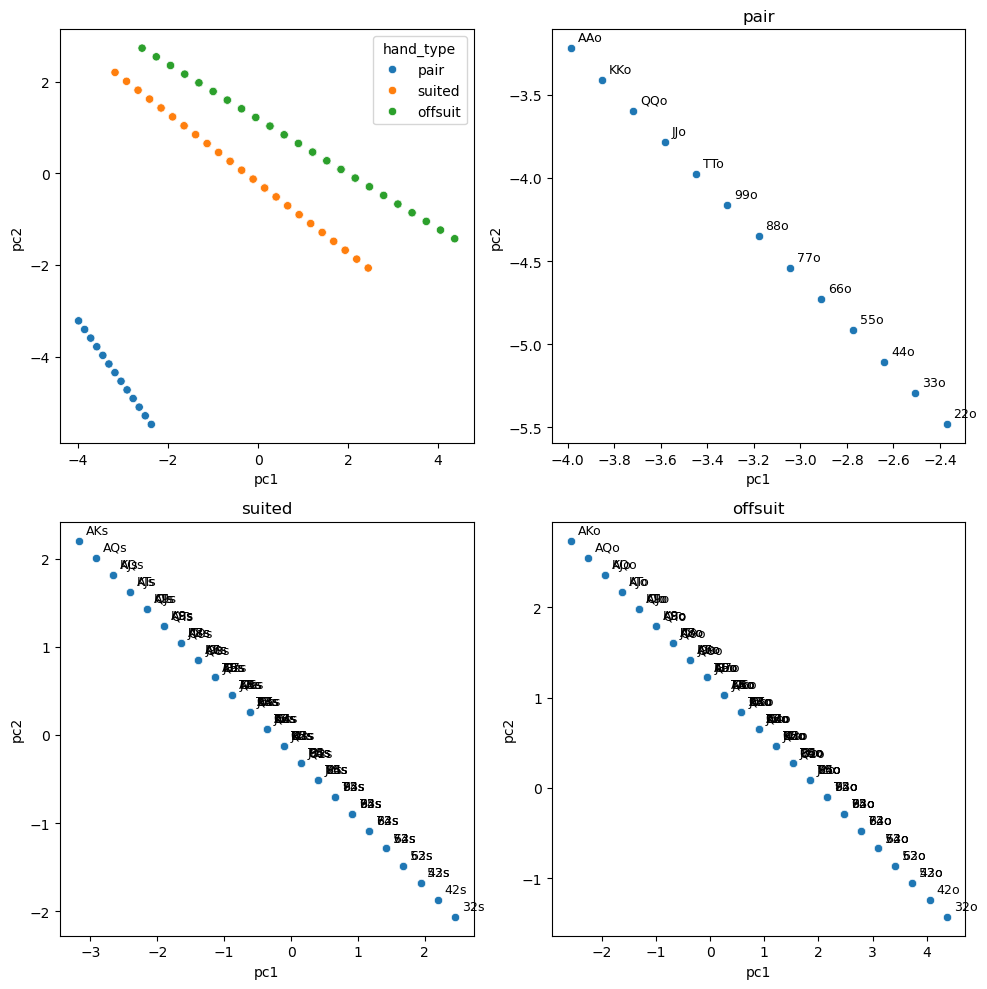

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(data=X, x='pc1', y='pc2', hue='hand_type', ax=axs[0,0])\

hand_types = X['hand_type'].unique()
for i, ax in enumerate(axs.flatten()[1:]):
    hand_type = hand_types[i]
    filtered_data = X[X['hand_type'] == hand_type]
        
    sns.scatterplot(data=filtered_data, x='pc1', y='pc2', ax=ax)
    ax.set_title(f'{hand_type}')
        
    for j, hand in enumerate(filtered_data['hand']):
        x_coord = filtered_data.iloc[j]['pc1']
        y_coord = filtered_data.iloc[j]['pc2']
        ax.annotate(
               hand,
            (x_coord, y_coord),
            fontsize=9,
            xytext=(5, 5),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

In [20]:
df['dom_block_pc1'] = X_pca[:,0]
df['dom_block_pc2'] = X_pca[:,1]

In [ ]:
# df.to_csv("data/raw/dom_block_data.csv", index=False)